## Import database from SQL to Python

In [36]:
import numpy as np
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

server   = r"LUONGTONVY\SQLEXPRESS"
database = "Final"

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    f"SERVER={server};DATABASE={database};"
    "Trusted_Connection=Yes;Encrypt=yes;TrustServerCertificate=yes"
)

engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

Dim_customer = "SELECT * FROM dbo.Dim_customer"
Dim_customer = pd.read_sql(Dim_customer, con=engine)

Dim_employees = "SELECT * FROM dbo.Dim_employees"
Dim_employees = pd.read_sql(Dim_employees, con=engine)

Dim_products = "SELECT * FROM dbo.Dim_products"
Dim_products = pd.read_sql(Dim_products, con=engine)

Facts_orders = "SELECT * FROM dbo.Facts_orders"
Facts_orders = pd.read_sql(Facts_orders, con=engine)

## Normalize by joining 3 Dims table into Facts table

In [37]:
df = (Facts_orders
        .merge(Dim_customer,left_on="customer_id",right_on="customer_id",how="left")
        .merge(Dim_employees,left_on="employee_id",right_on="employee_id",how="left")
        .merge(Dim_products,left_on="product_id",right_on="product_id",how="left"))

## Creat Chart
### Total sales, profit by region

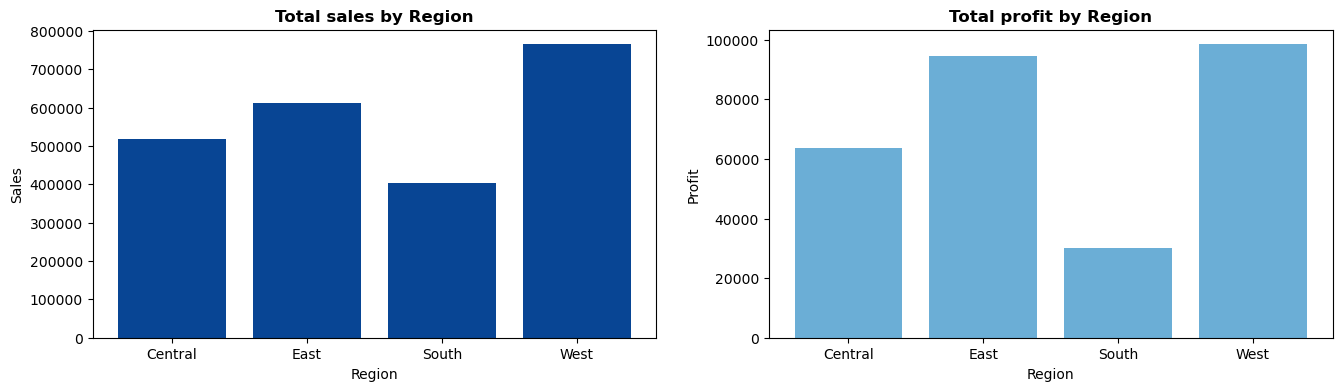

In [38]:
df_region_group = df.groupby ('region_x',as_index=False)[['sales','profit']].sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].bar(df_region_group['region_x'],df_region_group['sales'], color = '#084594')
axes[0].set_xlabel('Region',fontsize=10)
axes[0].set_ylabel('Sales',fontsize=10)
axes[0].set_title('Total sales by Region',fontweight='bold',fontsize=12)

axes[1].bar(df_region_group['region_x'],df_region_group['profit'], color = '#6BAED6')
axes[1].set_xlabel('Region',fontsize=10)
axes[1].set_ylabel('Profit',fontsize=10)
axes[1].set_title('Total profit by Region',fontweight='bold',fontsize=12)

plt.show()

### Top/Bottom 10 customers by sales

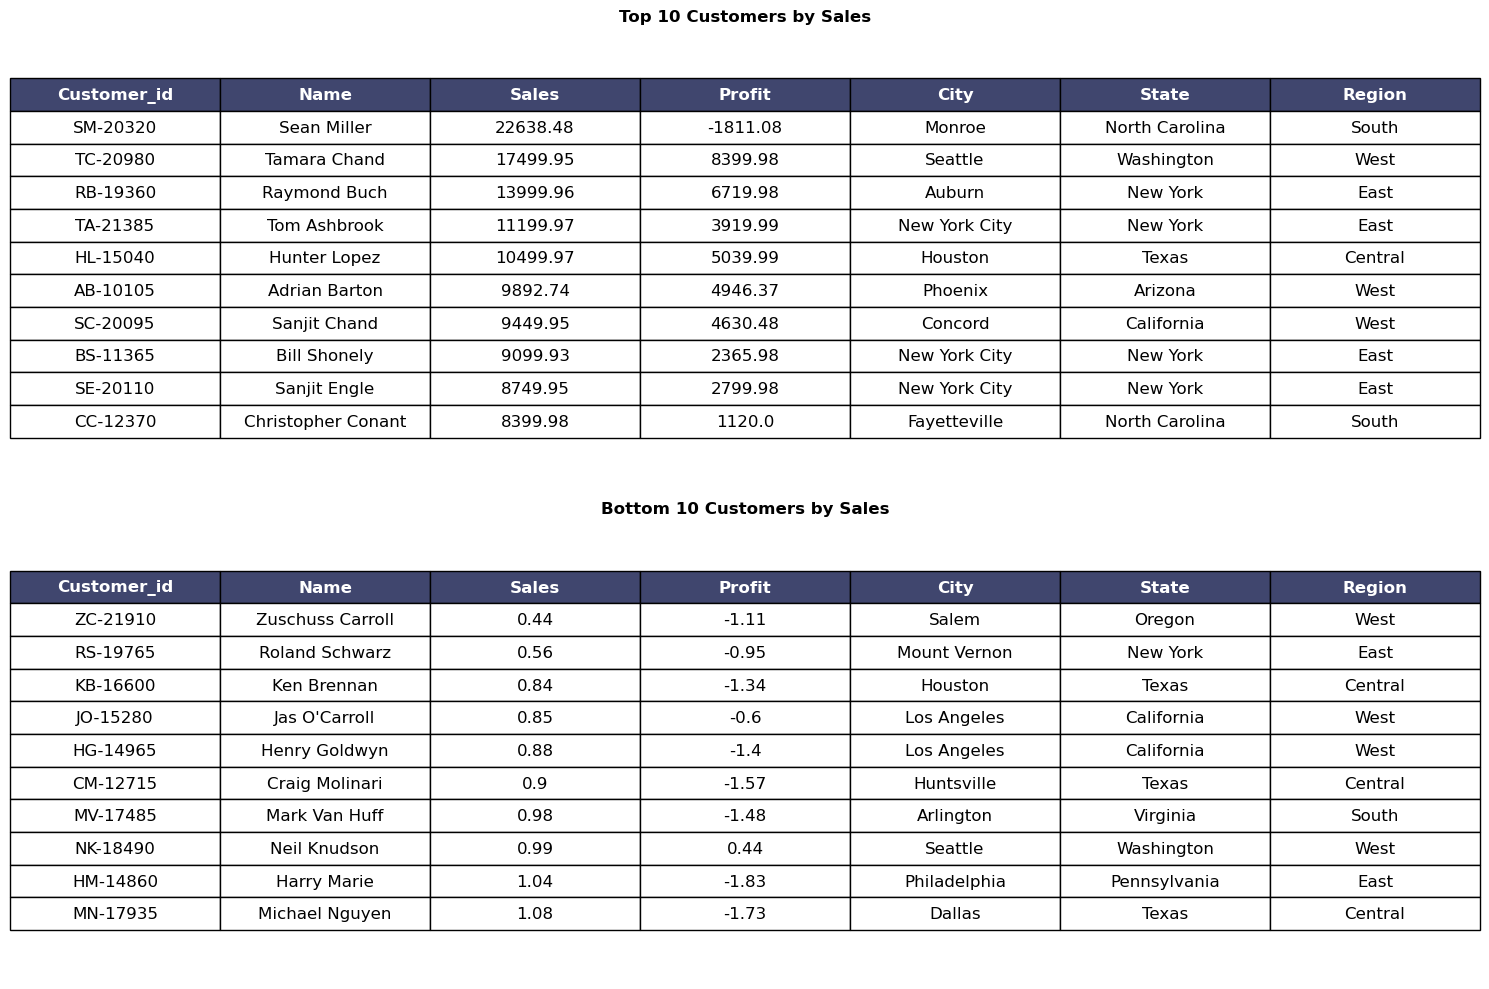

In [39]:
df_top10_customers= (df.sort_values(by='sales', ascending=False).head(10)[['customer_id','name_x','sales','profit','city_x','state','region_x']])
df_top10_customers= df_top10_customers.rename(columns={'customer_id':'Customer_id','name_x':'Name','sales':'Sales','profit':'Profit','city_x':'City','state':'State','region_x':'Region'})
df_bot10_customers=(df.sort_values(by='sales',ascending=True).head(10)[['customer_id','name_x','sales','profit','city_x','state','region_x']])
df_bot10_customers= df_bot10_customers.rename(columns={'customer_id':'Customer_id','name_x':'Name','sales':'Sales','profit':'Profit','city_x':'City','state':'State','region_x':'Region'})

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
axes[0].axis('off')
axes[1].axis('off')

table_top10_customers = axes[0].table(
    cellText=df_top10_customers.values,
    colLabels=df_top10_customers.columns,
    cellLoc='center',
    loc='center')
axes[0].set_title("Top 10 Customers by Sales", fontsize=12, fontweight='bold')

table_bot10_customers = axes[1].table(
    cellText=df_bot10_customers.values,
    colLabels=df_bot10_customers.columns,
    cellLoc='center',
    loc='center')
axes[1].set_title("Bottom 10 Customers by Sales", fontsize=12, fontweight='bold')

for s in [table_top10_customers, table_bot10_customers]:
    s.auto_set_font_size(False)
    s.set_fontsize(12)
    s.scale(1, 1.5)
    for (row, col), cell in s.get_celld().items():
        if row == 0:
            cell.set_text_props(fontweight='bold', color='white')
            cell.set_facecolor('#40466e')

plt.tight_layout()
plt.show()

### Total Profit and Sales by Employees

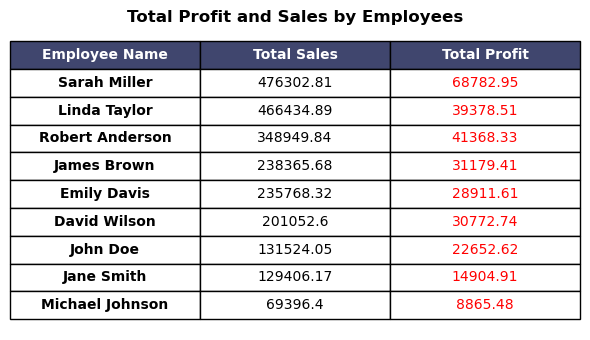

In [40]:
df_employees_profit_sales_group = df.groupby ('name_y',as_index=False)[['sales','profit']].sum()
df_employees_profit_sales_group = df_employees_profit_sales_group.sort_values(by='sales',ascending=False)
df_employees_profit_sales_group=df_employees_profit_sales_group.rename(columns={'name_y':'Employee Name','sales':'Total Sales','profit':'Total Profit'})

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.axis('off')

table_employees_profit_sales = ax.table(
    cellText=df_employees_profit_sales_group.values,
    colLabels=df_employees_profit_sales_group.columns,
    cellLoc='center',
    loc='center')
ax.set_title("Total Profit and Sales by Employees", fontsize=12, fontweight='bold')

table_employees_profit_sales.auto_set_font_size(False)
table_employees_profit_sales.set_fontsize(10)
table_employees_profit_sales.scale(1, 1.5)

for (row, col), cell in table_employees_profit_sales.get_celld().items():
    if col == 0:
        cell.set_text_props(fontweight='bold')
    if col == 2:
        cell.set_text_props(color='red')
    if row == 0:
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#40466e')

plt.tight_layout()
plt.show()

### Sales and Profit by Category

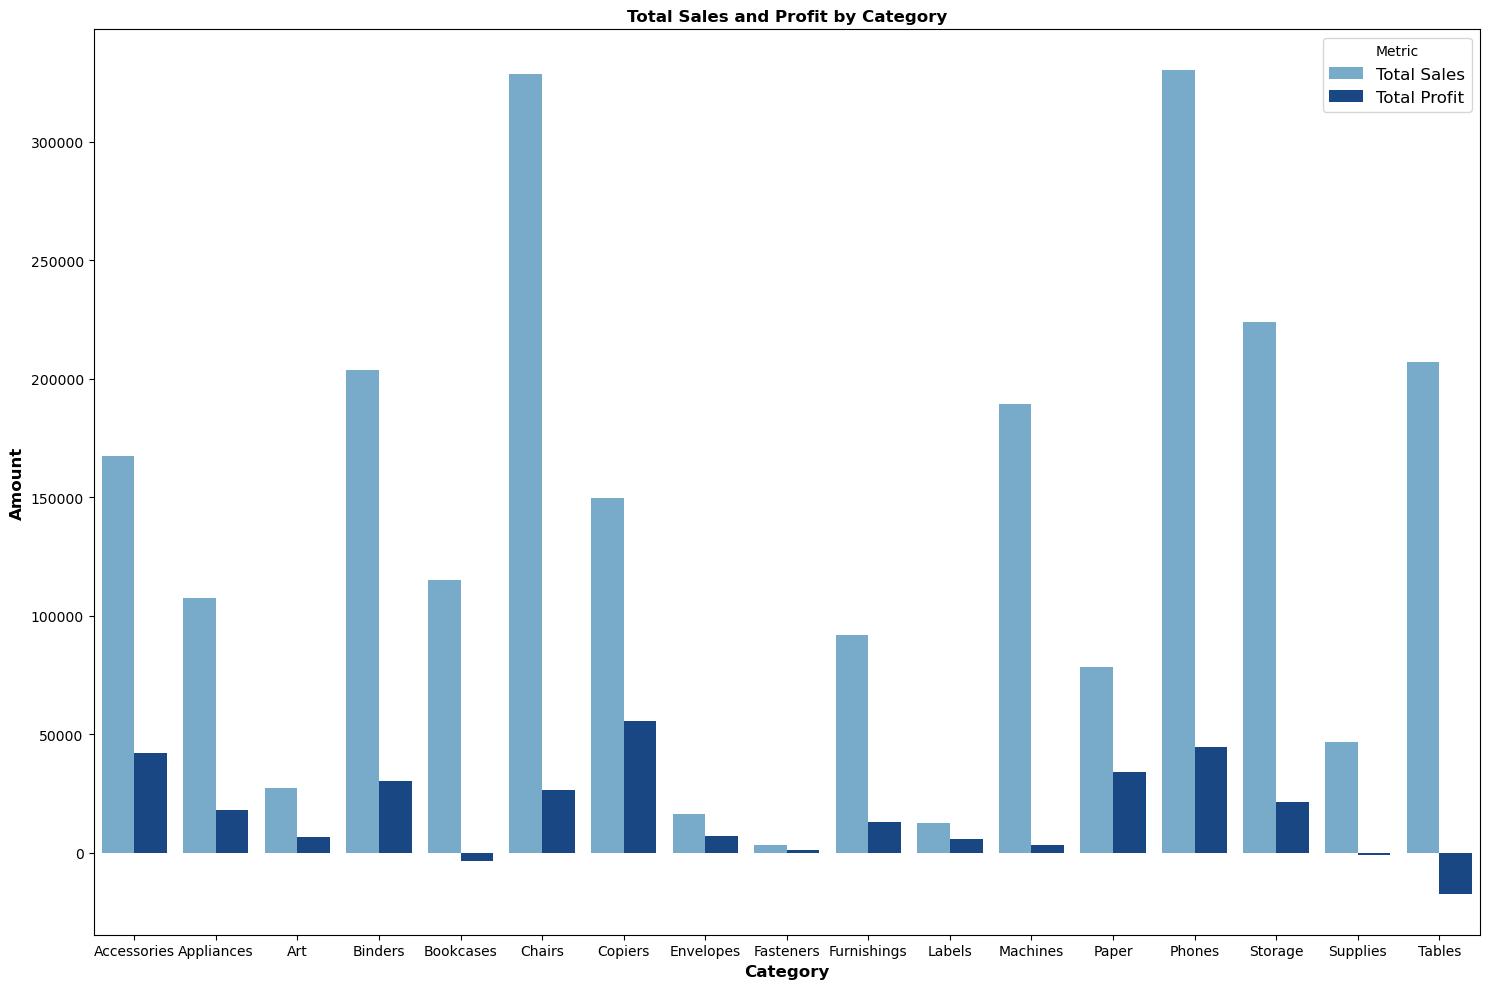

In [41]:
df_Category_profit_sales_group=df.groupby(by='category',as_index=False)[['sales','profit']].sum()
df_Category_profit_sales_group=df_Category_profit_sales_group.rename(columns={'category':'Category','sales':'Total Sales','profit':'Total Profit'})
df_Category_profit_sales_group=df_Category_profit_sales_group.melt(id_vars='Category',value_vars=['Total Sales','Total Profit'],var_name='Total',value_name='Amount')

plt.figure(figsize=(15, 10))
sns.barplot(data=df_Category_profit_sales_group, x='Category', y='Amount', hue='Total', palette=['#6BAED6','#084594'])

plt.title('Total Sales and Profit by Category', fontsize=12, fontweight='bold')
plt.xlabel('Category',fontsize=12,fontweight='bold')
plt.ylabel('Amount',fontsize=12,fontweight='bold')
plt.legend(title='Metric',fontsize=12)

plt.tight_layout()
plt.show()

### Sales and Profit Trend by Year

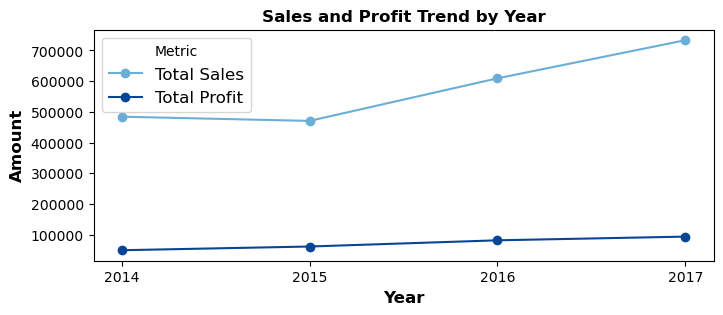

In [42]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_year']= df['order_date'].dt.year

df_trend_by_year = (
    df.groupby('order_year', as_index=False)[['sales','profit']].sum()
      .rename(columns={'order_year':'Year', 'sales':'Total Sales', 'profit':'Total Profit'})
      .sort_values('Year'))
years = df_trend_by_year['Year'].tolist()

plt.figure(figsize=(8,3))
plt.plot(df_trend_by_year['Year'],df_trend_by_year['Total Sales'],label='Total Sales',color='#6BAED6',linestyle='-',marker='o')
plt.plot(df_trend_by_year['Year'],df_trend_by_year['Total Profit'],label='Total Profit',color='#084594',linestyle='-',marker='o')

plt.title('Sales and Profit Trend by Year',fontweight='bold',fontsize=12)
plt.xlabel('Year',fontweight='bold',fontsize=12)
plt.xticks(years)
plt.ylabel('Amount',fontweight='bold',fontsize=12)
plt.legend(title='Metric',fontsize=12)

plt.show()

### Sales and Profit Trend by Month

In [43]:
df['order_month']= df['order_date'].dt.month

def get_df_trend_by_month (df,year):
    return (
        df[df['order_year'] == year]
            .groupby('order_month',as_index=False)[['sales','profit']].sum()
            .rename(columns={'order_month': 'Month','sales':'Total Sales', 'profit':'Total Profit'})
            .sort_values('Month'))

df_trend_by_month_2014 = get_df_trend_by_month(df, 2014)
df_trend_by_month_2015 = get_df_trend_by_month(df, 2015)
df_trend_by_month_2016 = get_df_trend_by_month(df, 2016)
df_trend_by_month_2017 = get_df_trend_by_month(df, 2017)


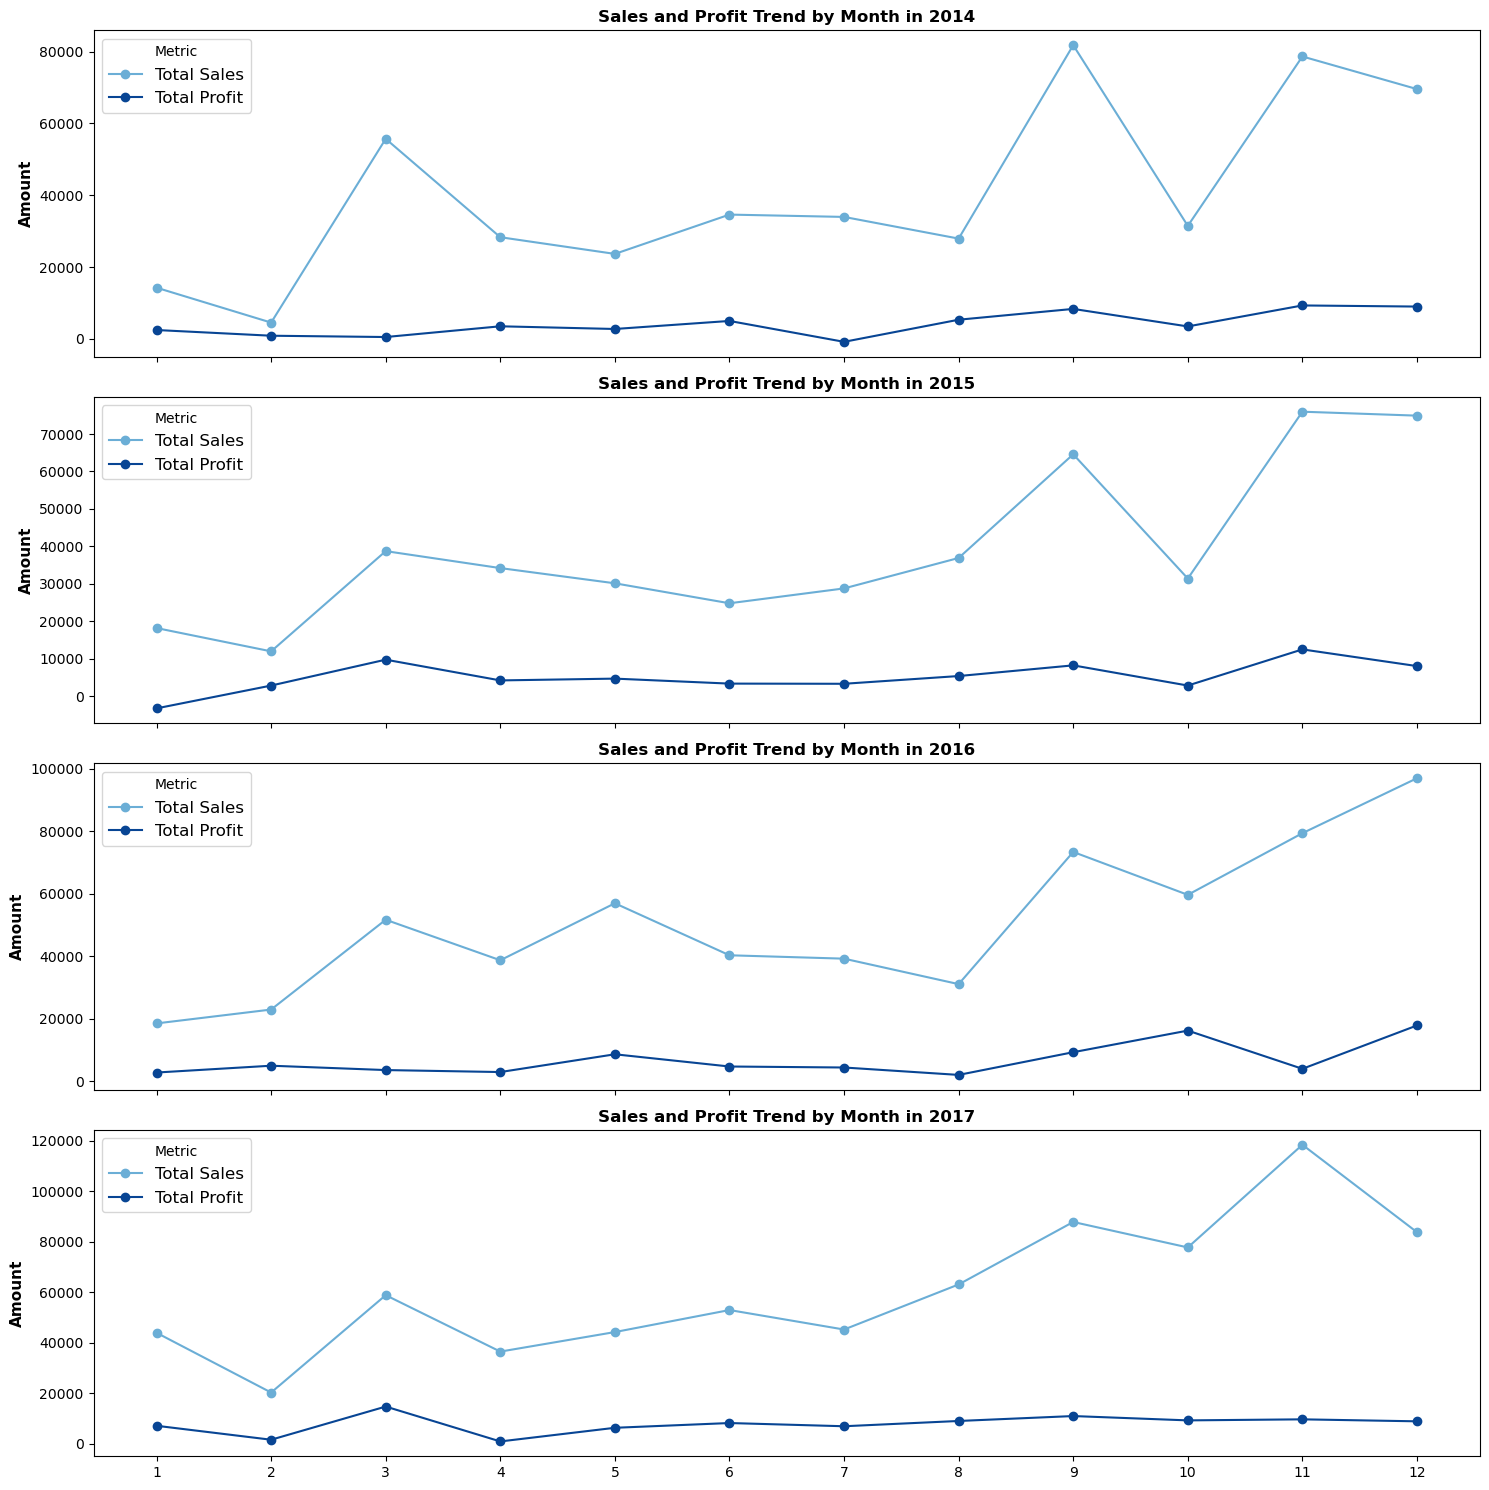

In [44]:
fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

plots = [
    (df_trend_by_month_2014, 2014),
    (df_trend_by_month_2015, 2015),
    (df_trend_by_month_2016, 2016),
    (df_trend_by_month_2017, 2017),
]

for ax, (dfname, year) in zip(axes, plots):
    ax.plot(dfname['Month'], dfname['Total Sales'],  label='Total Sales',
            color='#6BAED6', linestyle='-', marker='o')
    ax.plot(dfname['Month'], dfname['Total Profit'], label='Total Profit',
            color='#084594', linestyle='-', marker='o')
    ax.set_title(f'Sales and Profit Trend by Month in {year}', fontweight='bold', fontsize=12)
    ax.set_ylabel('Amount', fontweight='bold', fontsize=11)
    ax.legend(title='Metric', fontsize=12)
    ax.set_xticks(list(range(1, 13)))

plt.tight_layout()
plt.show()

### Discount vs Profit trade-off

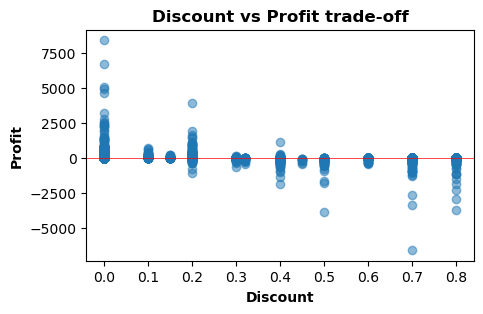

In [45]:
df_discount_profit = df[['profit','discount']]

plt.figure(figsize=(5,3))
plt.scatter(df_discount_profit['discount'], df_discount_profit['profit'], alpha=0.5)
plt.title('Discount vs Profit trade-off', fontsize=12,fontweight='bold')
plt.xlabel('Discount',fontweight='bold')
plt.ylabel('Profit',fontweight='bold')
plt.axhline(0, color="red", linestyle="-", linewidth=0.5)
plt.show()

### Profit margin by Category

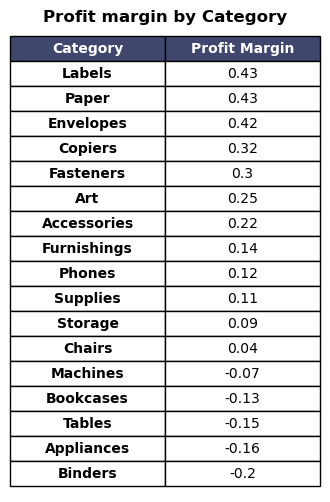

In [46]:
df_profitmargin_subcategory = df.groupby('category',as_index=False)['profit_margin'].mean().rename(columns={'category':'Category','profit_margin':'Profit Margin'}).sort_values(by='Profit Margin',ascending=False)
df_profitmargin_subcategory['Profit Margin']=df_profitmargin_subcategory['Profit Margin'].round(2)

fig, ax = plt.subplots(figsize=(4, 6))
ax.axis('off')

table_profitmargin_subcategory = ax.table(
    cellText=df_profitmargin_subcategory.values,
    colLabels=df_profitmargin_subcategory.columns,
    cellLoc='center',
    loc='center')
ax.set_title('Profit margin by Category', fontsize=12, fontweight='bold')

table_profitmargin_subcategory.auto_set_font_size(False)
table_profitmargin_subcategory.set_fontsize(10)
table_profitmargin_subcategory.scale(1, 1.5)

for (row, col), cell in table_profitmargin_subcategory.get_celld().items():
    if col == 0:
        cell.set_text_props(fontweight='bold')
    if col == 2:
        cell.set_text_props(color='red')
    if row == 0:
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#40466e')

plt.show()

## Delivery SLA analysis

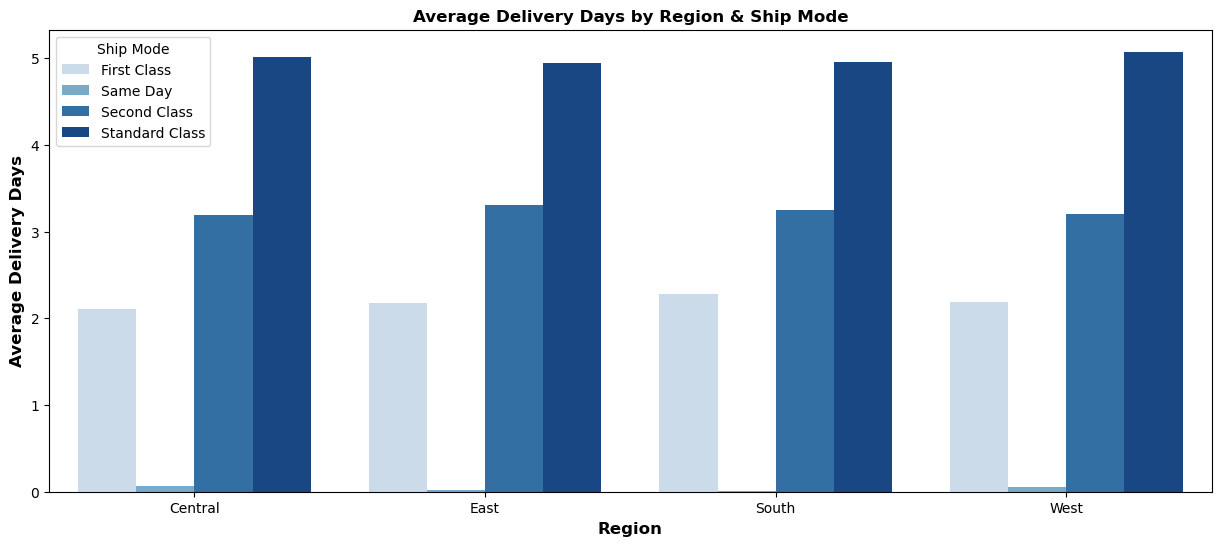

In [47]:
sla_by_region_shipmode = Facts_orders.merge(Dim_customer, on='customer_id').groupby(['region','ship_mode'])['delivery_days'].mean().reset_index()

plt.figure(figsize=(15,6))
sns.barplot(data=sla_by_region_shipmode, x='region', y='delivery_days', hue='ship_mode', palette=['#C6DBEF','#6BAED6','#2171B5','#084594'])
plt.title("Average Delivery Days by Region & Ship Mode", fontweight='bold',fontsize=12)
plt.xlabel("Region", fontweight='bold',fontsize=12)
plt.ylabel("Average Delivery Days", fontweight='bold',fontsize=12)
plt.legend(title="Ship Mode")
plt.show()

### Churn Analysis

In [48]:
snapshot_date = Facts_orders['order_date'].max() + pd.Timedelta(days=1)

In [49]:
rfm = Facts_orders.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,  
    'order_id': 'nunique','sales': 'sum'}).reset_index()

rfm.rename(columns={'order_date':'Recency','order_id':'Frequency','sales':'Monetary'}, inplace=True)

In [50]:
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Segment'] = 'R'+rfm['R'].astype(str) + 'F'+rfm['F'].astype(str) + 'M'+rfm['M'].astype(str)
rfm['RFM_Score']   = rfm[['R','F','M']].sum(axis=1)

In [51]:
def label_customer (row):
    r,f,m=row['R'], row['F'], row['M']
    if r >= 4 and f >= 4 and m >= 4:
        return 'VIP'
    elif f >=4 and m>=3:
        return 'Loyal'
    elif r>=4 and (f<=2 or m <=2):
        return 'Potential'
    elif r >=3 and f >=2 and m >=2:
        return 'Promising'
    elif r <=2 and (f>=4 or m>=4):
        return 'At risk'
    elif r <=2 and f <=2 and m <=2:
        return 'Lost'
    else:
        return 'Regular'

rfm['customer_lable']=rfm.apply(label_customer,axis=1)
rfm

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,customer_lable
0,AA-10315,185,5,5563.56,2,2,5,R2F2M5,9,At risk
1,AA-10375,20,9,1056.39,5,5,2,R5F5M2,12,Potential
2,AA-10480,260,4,1790.51,1,1,3,R1F1M3,5,Regular
3,AA-10645,56,6,5086.94,3,3,5,R3F3M5,11,Promising
4,AB-10015,416,3,886.15,1,1,1,R1F1M1,3,Lost
...,...,...,...,...,...,...,...,...,...,...
788,XP-21865,44,11,2374.66,4,5,3,R4F5M3,12,Loyal
789,YC-21895,5,5,5454.35,5,3,5,R5F3M5,13,Promising
790,YS-21880,10,8,6720.44,5,4,5,R5F4M5,14,VIP
791,ZC-21910,55,13,8025.70,3,5,5,R3F5M5,13,Loyal


C:\Users\luong\AppData\Local\Temp\ipykernel_23660\1464287215.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_heatmap = rfm.pivot_table(


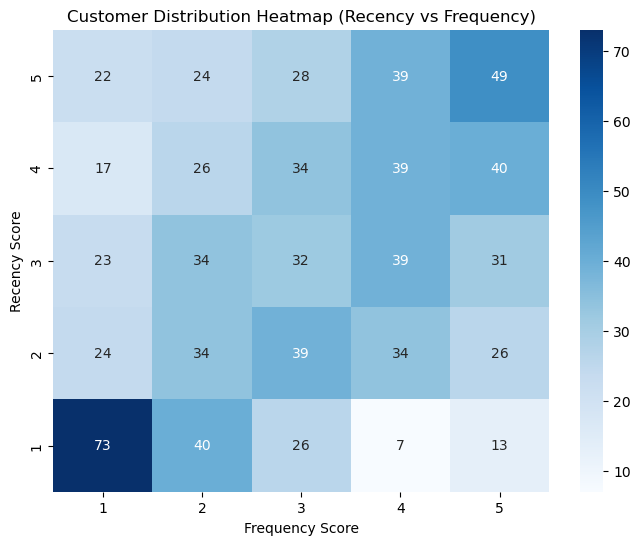

In [52]:
rfm_heatmap = rfm.pivot_table(
    index='R', 
    columns='F', 
    values='customer_id', 
    aggfunc='count', 
    fill_value=0)

plt.figure(figsize=(8,6))
sns.heatmap(rfm_heatmap, annot=True, fmt='d', cmap="Blues")
plt.title('Customer Distribution Heatmap (Recency vs Frequency)')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()